In [2]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/95/6c/d2a1636591e204667f320481b036acc9c526608bcc2319be71cce148102d/xgboost-3.0.0-py3-none-macosx_10_15_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd

# This is the classifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import matplotlib.pyplot as plt

# This displays all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# This module lets us save our models once we fit them.
import pickle

# Read in data
file = '../DATA/Churn_Modelling.csv'
df_original = pd.read_csv(file)
df_original.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [4]:
# Drop useless and sensitive (Gender) cols
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], 
                            axis=1)

# Dummy encode categoricals
churn_df2 = pd.get_dummies(churn_df, drop_first='True')
churn_df2.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1        101348.88       1              False            False  
1               1        112542.58       0              False             True  
2               0        113931.57       1              False            False  
3               0         93826.63       0              False            False  
4               1         79084.10       0              False             True

In [5]:
# Define the y (target) variable
y = churn_df2["Exited"]

# Define the X (predictor) variables
X = churn_df2.copy()
X = X.drop("Exited", axis = 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y, random_state=42)

In [7]:
# Modeling
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }    

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [8]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 17min 34s, sys: 27.1 s, total: 18min 2s
Wall time: 1min 34s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [17]:
path = '../DATA/'

# Pickle the model
with open(path + 'xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write) 

# Open pickled model
with open(path+'xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

# Open pickled random forest model
with open(path+'rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)
    
rf_cv.fit(X_train, y_train)

print('F1 score random forest CV: ', rf_cv.best_score_)
print('F1 score XGB CV: ', xgb_cv.best_score_)

F1 score random forest CV:  0.580528563620339
F1 score XGB CV:  0.5815449412084907


In [11]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [12]:
# Create xgb model results table
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

Model        F1    Recall  Precision  Accuracy
0  XGBoost CV  0.581545  0.474491   0.755036    0.8612

In [13]:
# Predict on test data
xgb_cv_preds = xgb_cv.predict(X_test)
print('F1 score final XGB model: ', f1_score(y_test, xgb_cv_preds))
print('Recall score final XGB model: ', recall_score(y_test, xgb_cv_preds))
print('Precision score final XGB model: ', precision_score(y_test, xgb_cv_preds))
print('Accuracy score final XGB model: ', accuracy_score(y_test, xgb_cv_preds))

F1 score final XGB model:  0.6059880239520958
Recall score final XGB model:  0.49705304518664045
Precision score final XGB model:  0.7760736196319018
Accuracy score final XGB model:  0.8684


In [14]:
# Create helper function to plot confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot()
    plt.show()

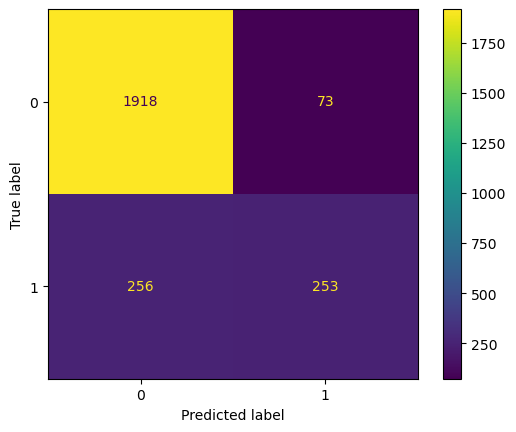

In [15]:
conf_matrix_plot(xgb_cv, X_test, y_test)

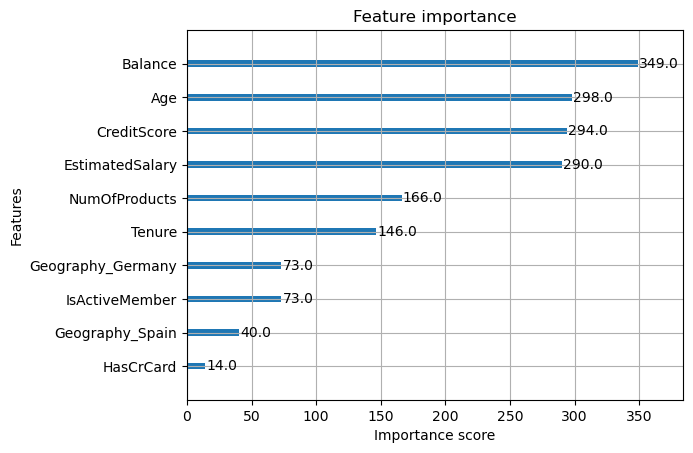

In [16]:
# Feature importance
plot_importance(xgb_cv.best_estimator_);